#### Intraday Strategy based on overnight change and deviation from rolling mean of UNL

In this strategy, I have combined two indicators to generate a trading signal. This is also an intraday strategy where positions are squared off at the end of the day. The trading signal is generated as follows:


If overnight change in UNL is positve and if Open price is greater than rolling mean of previous n periods, go long on ETQ or RRC. 
Else if overnight change in UNL is negative and if Open Price is less than rolling mean of previous n periods, go short.




The results below are for rolling window period of 10. I start with an initial capital of 10,000 and each position is for 100 shares. A graph for cummulative earnings is plotted for both RRC and ETQ. Sharpe ratio is 1.74 and 2.64 for RRC and ETQ respectively.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
def read_data(pd_frame):
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
    data = pd.read_csv(pd_frame, parse_dates=['Date'], date_parser=dateparse)
    data = data.iloc[::-1]
    data = data.set_index('Date')
    data.name = pd_frame[-7:-4]
    return data

In [3]:
unl = read_data('data/unl.csv')

In [4]:
unl['Open_close'] = unl['Open'] - unl['Close'].shift(1)
unl['Open_close_sign'] = np.sign(unl['Open'] - unl['Close'].shift(1))
unl['rolling_mean'] = unl['Open'].rolling(window=10).mean()
unl['diff'] = unl['Open'] - unl['rolling_mean']
# unl['signal_diff_pct'].plot()
unl['trading signal'] = 0
unl.loc[(unl['diff'] > 0) & (unl['Open_close_sign'] == 1), 'trading signal'] = 1
unl.loc[(unl['diff'] < 0) & (unl['Open_close_sign'] == -1), 'trading signal'] = -1
unl.to_excel('unl_signal.xlsx')

In [5]:
def intraday_strategy(data):
    data['profit'] = unl['trading signal']*(data['Close']-data['Open'])*100
    data['total_everyday'] = 10000 + data['profit']
    data['total'] = 10000 + data['profit'].cumsum()
    data['returns'] = data['total'].pct_change()
    data['returns'].fillna(0.0, inplace=True)
    data['returns'].replace([np.inf, -np.inf], 0.0, inplace=True)
    data['returns'].replace(-1.0, 0.0, inplace=True)
    data['cum returns'] = (data['returns'] + 1.0).cumprod()
#     data.to_excel('etq_intraday_2.xlsx')
    sharpe_ratio = (data['returns'].mean()*np.sqrt(252))/data['returns'].std()
    return data, sharpe_ratio 


Sharpe ratio for rrc is 1.741948


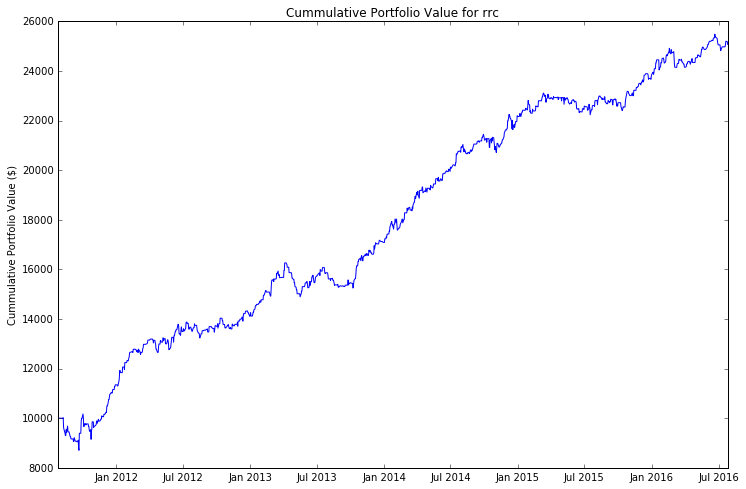

In [6]:
data = read_data('data/rrc.csv')
data, sharpe_ratio = intraday_strategy(data)
print 'Sharpe ratio for rrc is %f' % (sharpe_ratio)
f, ax1 = plt.subplots(1)
ax1.plot(data.index, data['total'])
ax1.set_ylabel("Cummulative Portfolio Value ($)")
ax1.set_title("Cummulative Portfolio Value for rrc")

Sharpe ratio for etq is 2.643843


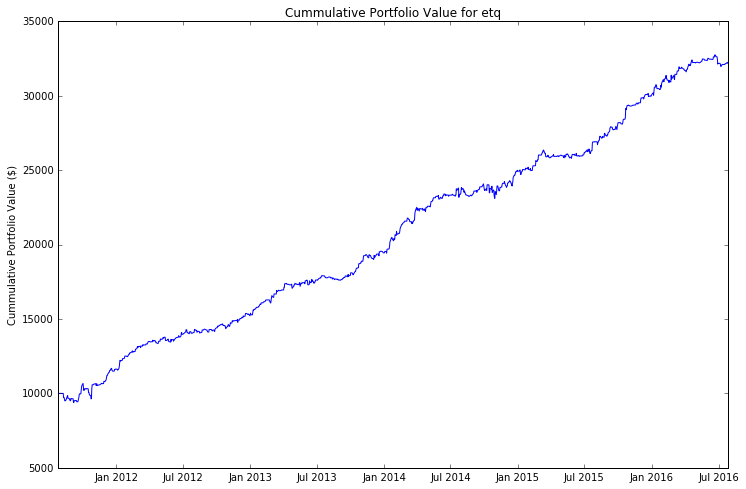

In [7]:
del data
data = read_data('data/etq.csv')
data, sharpe_ratio = intraday_strategy(data)
print 'Sharpe ratio for etq is %f' % (sharpe_ratio)
f, ax1 = plt.subplots(1)
ax1.plot(data.index, data['total'])
ax1.set_ylabel("Cummulative Portfolio Value ($)")
ax1.set_title("Cummulative Portfolio Value for etq")